In [1]:
import numpy as np
import pandas as pd
import gc
import time
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import base64
import os
from sklearn.preprocessing import StandardScaler
import datetime
from collections import deque

In [2]:
num_folds = 5
_num_folds = 5

In [3]:
def pad_bins(hist, bins):
    hist = deque(hist)
    bins = deque(bins)
    hist.appendleft(0)
    hist.append(0)
    bins.appendleft(-np.inf)
    bins.append(np.inf)
    return np.array(hist), np.array(bins)

In [4]:
def fractional_part(train_df, test_df, columns):
    df = pd.concat([train_df, test_df])
    for col in columns[:10]:
        df[col+"_frac_part"] = df[col].apply(lambda x: x-int(x))
    return df[:len(train_df)], df[len(train_df):]

In [5]:
def target_density_difference(train_df, test_df, columns, target):
    for col in columns[:10]:
        #print("Column {}".format(col))
        hist, bins = np.histogram(train_df[col],bins='fd')
        n_bins=len(hist)
        
        hist_1, bins_1 = np.histogram(train_df[target==1][col],bins=n_bins)
        hist_1, bins_1 = pad_bins(hist_1, bins_1)
        hist_1 = hist_1/hist_1.sum()
        
        hist_0, bins_0 = np.histogram(train_df[target==0][col],bins=n_bins)
        hist_0, bins_0 = pad_bins(hist_0, bins_0)
        hist_0 = hist_0/hist_0.sum()
        
        train_df[col+"_1_density"] = [hist_1[np.searchsorted(bins_1,x)-1] for x in train_df[col]]
        test_df[col+"_1_density"] = [hist_1[np.searchsorted(bins_1,x)-1] for x in test_df[col]]

        train_df[col+"_0_density"] = [hist_0[np.searchsorted(bins_0,x)-1] for x in train_df[col]]
        test_df[col+"_0_density"] = [hist_0[np.searchsorted(bins_0,x)-1] for x in test_df[col]]

        train_df[col+"_target_diff"] = train_df[col+"_1_density"] - train_df[col+"_0_density"]
        #train_df[col+"_target_diff"] += np.random.normal(0,1,len(train_df))/1e4
        test_df[col+"_target_diff"] = test_df[col+"_1_density"] - test_df[col+"_0_density"]

        train_df.drop(columns=[col+"_1_density", col+"_0_density"], inplace=True)
        test_df.drop(columns=[col+"_1_density", col+"_0_density"], inplace=True)
    return train_df, test_df

In [6]:
def fractional_part_density(train_df, test_df, columns, target):
    for col in columns[:10]:
        col_name = col+"_frac_part"
        hist, bins = np.histogram(train_df[col_name],bins='fd')
        n_bins=len(hist)
        
        hist_1, bins_1 = np.histogram(train_df[target==1][col_name],bins=n_bins)
        hist_1, bins_1 = pad_bins(hist_1, bins_1)
        hist_1 = hist_1/hist_1.sum()
        
        hist_0, bins_0 = np.histogram(train_df[target==0][col_name],bins=n_bins)
        hist_0, bins_0 = pad_bins(hist_0, bins_0)
        hist_0 = hist_0/hist_0.sum()
        
        train_df[col+"_frac_1_density"] = [hist_1[np.searchsorted(bins_1,x)-1] for x in train_df[col_name]]
        test_df[col+"_frac_1_density"] = [hist_1[np.searchsorted(bins_1,x)-1] for x in test_df[col_name]]

        train_df[col+"_frac_0_density"] = [hist_0[np.searchsorted(bins_0,x)-1] for x in train_df[col_name]]
        test_df[col+"_frac_0_density"] = [hist_0[np.searchsorted(bins_0,x)-1] for x in test_df[col_name]]

        train_df[col+"_frac_target_diff"] = train_df[col+"_frac_1_density"] - train_df[col+"_frac_0_density"]
        test_df[col+"_frac_target_diff"] = test_df[col+"_frac_1_density"] - test_df[col+"_frac_0_density"]

        train_df.drop(columns=[col+"_frac_1_density", col+"_frac_0_density"], inplace=True)
        test_df.drop(columns=[col+"_frac_1_density", col+"_frac_0_density"], inplace=True)
    return train_df, test_df

In [7]:
public_index = np.load("../input/public_LB.npy")
private_index = np.load("../input/private_LB.npy")
synthetic_index = np.load("../input/synthetic_samples_indexes.npy")

In [8]:
print('Load Train Data.')
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')
print('\nShape of Train Data: {}\t Shape of Test Data: {}'
    .format(train_df.shape, test_df.shape))

train_labels = train_df['target']
train_index = np.array(train_df.index)

train_df.drop(['ID_code', 'target'], axis=1, inplace=True)
test_df.drop(['ID_code'], axis=1, inplace=True)

columns = train_df.columns

Load Train Data.

Shape of Train Data: (200000, 202)	 Shape of Test Data: (200000, 201)


In [9]:
test_preds = np.zeros(test_df.shape[0])
feature_importance = pd.DataFrame()

skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
ids = list(skf.split(train_index, train_labels))[-1]

X_train, y_train = train_df.loc[ids[0],:], train_labels[ids[0]]
X_val, y_val = train_df.loc[ids[1],:], train_labels[ids[1]]

_skf = StratifiedKFold(n_splits=_num_folds, shuffle=True, random_state=42)
_train_index = ids[0]
_train_labels = y_train
X_train = pd.DataFrame()
y_train = np.array([])

In [10]:
for _counter, _ids in enumerate(_skf.split(_train_index, _train_labels)):
    print('\nInner Fold {}'.format(_counter+1))
    _train_df = train_df.loc[_train_index[_ids[0]],:]
    _y_train = train_labels.loc[_train_index[_ids[0]]]
    _test_df = train_df.loc[_train_index[_ids[1]],:]
    _y_test = train_labels.loc[_train_index[_ids[1]]]
    
    #_train_df, _test_df = fractional_part_density(_train_df, _test_df, columns, _y_train)
    _train_df, _test_df = target_density_difference(_train_df, _test_df, columns, _y_train)
    X_train = pd.concat([X_train, _test_df])
    y_train = np.append(y_train, _y_test)
    del _train_df, _test_df


Inner Fold 1

Inner Fold 2

Inner Fold 3

Inner Fold 4

Inner Fold 5


In [11]:
#_, X_val = fractional_part_density(train_df.loc[ids[0],:], X_val, columns, train_labels[ids[0]])
_, X_val = target_density_difference(train_df.loc[ids[0],:], X_val, columns, train_labels[ids[0]])

In [12]:
print("DONE!")

DONE!


In [13]:
#_, X_test = fractional_part_density(train_df.loc[ids[0],:], test_df.loc[:,:], columns, train_labels[ids[0]])
_, X_test = target_density_difference(train_df.loc[ids[0],:], test_df.loc[:,:], columns, train_labels[ids[0]])

In [14]:
X_test.shape, test_df.shape, train_df.shape

((200000, 210), (200000, 210), (200000, 200))

In [15]:
private_df, public_df, synthetic_df = X_test.iloc[private_index], X_test.iloc[public_index], X_test.iloc[synthetic_index]

C:\Users\anshu\AppData\Roaming\Python\Python36\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


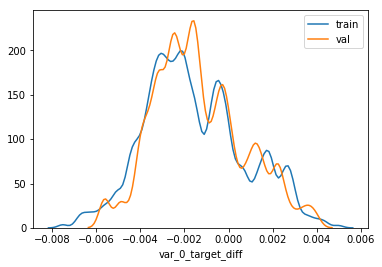

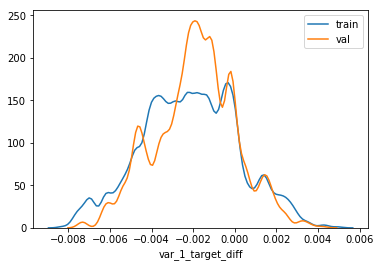

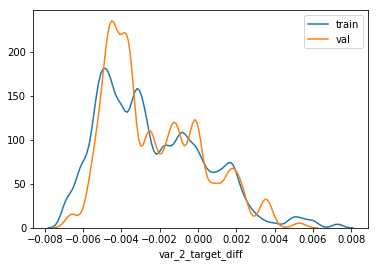

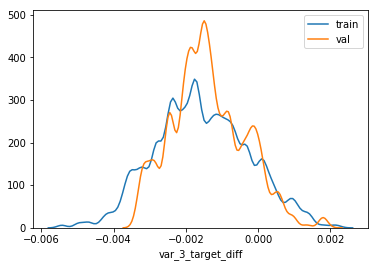

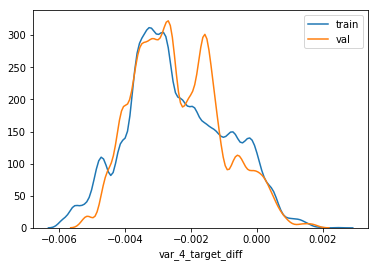

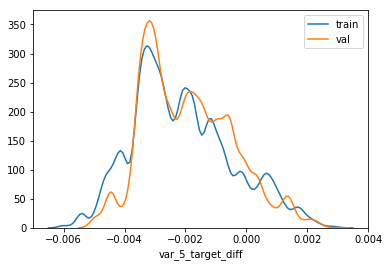

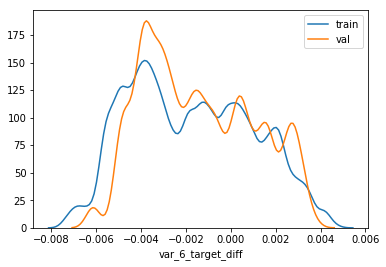

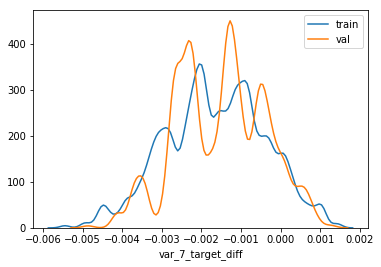

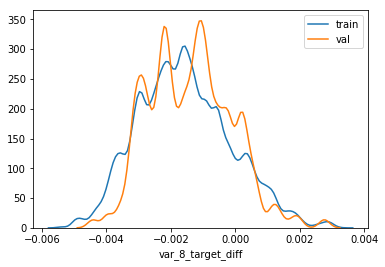

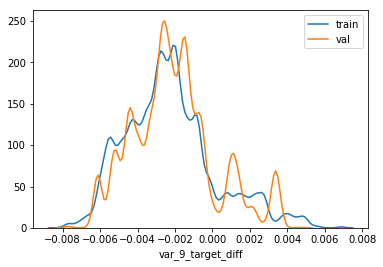

In [16]:
for var in columns[:10]:
    plt.plot()
    #bins, _ = np.histogram(X_train[var+"_frac_target_diff"],bins='fd')
    bins, _ = np.histogram(X_train[var+"_target_diff"],bins='fd')
    #sns.distplot(public_df[var+"_frac_target_diff"], label="public", bins=len(bins), hist=False)
    #sns.distplot(private_df[var+"_frac_target_diff"], label="private", bins=len(bins), hist=False)
    #sns.distplot(X_train[var+"_frac_target_diff"], label="train", bins=len(bins), hist=False)
    sns.distplot(X_train[var+"_target_diff"], label="train", bins=len(bins), hist=False)
    #sns.distplot(X_train[y_train==1][var+"_frac_target_diff"], label="train target=1", bins=len(bins), hist=False)
    #sns.distplot(X_train[y_train==0][var+"_frac_target_diff"], label="train target=0", bins=len(bins), hist=False)
    
    #sns.distplot(X_val[var+"_frac_target_diff"], label="val", bins=len(bins), hist=False)
    sns.distplot(X_val[var+"_target_diff"], label="val", bins=len(bins), hist=False)
    #sns.distplot(X_val[y_val==1][var+"_frac_target_diff"], label="val target=1", bins=len(bins), hist=False)
    #sns.distplot(X_val[y_val==0][var+"_frac_target_diff"], label="val target=0", bins=len(bins), hist=False)
    #sns.distplot(test_df[var+"_frac_target_diff"], label="test", bins=len(bins), hist=False)
    plt.legend()
    plt.show()